**Sources:**

The code is a further development of this preliminary project:

[1] https://github.com/bjorneme/preliminary/tree/main

The state-of-the-art model used as inspiration for multi-label classification on ChestX-ray14 is:

[2] https://github.com/syednabilashraf/SynthEnsemble/tree/main

The code used for TTA is:

[3] https://github.com/taheeraahmed/master-thesis

**Import Libraries**

In [1]:
pip install lightly mambavision transformers mamba_ssm timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import zipfile

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from torch.amp import GradScaler, autocast

# Hugging Face transformers to load the Vision Mamba model
from transformers import AutoConfig, AutoModelForImageClassification

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Model
MODEL_NAME = "saurabhati/VMamba_ImageNet_83.6"

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 1
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [4]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [ ]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# TODO: Uncomment to extract data from zip
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [6]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [7]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train dataset size: {len(train_df)}. Number of unique patients: {len(train_patients)}")
print(f"Validation size: {len(val_df)}. Number of unique patients: {len(val_patients)}")
print(f"Test size: {len(test_df)}. Number of unique patients: {len(test_patients)}")

Train dataset size: 78614. Number of unique patients: 21563
Validation size: 11212. Number of unique patients: 3081
Test size: 22294. Number of unique patients: 6161


**Define Dataset for Chest X-ray images**

In [8]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Randomly 224x224 crops
    transforms.RandomCrop(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=mean, std=std)
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Create 10 crops
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.ToTensor()(crop) for crop in crops
    ])),

    # Normalize using ImageNet mean and std
    transforms.Lambda(lambda crops: torch.stack(
        [transforms.Normalize(mean, std)(crop) for crop in crops]
    ))
])

**Create Datasets**

In [10]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [12]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using MambaVision as the base model.
    """
    def __init__(self, device, model_name, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Vision Mamba model
        self.base_model = AutoModelForImageClassification.from_pretrained(model_name,trust_remote_code=True).to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.head = nn.Linear(self.base_model.head.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x).logits

# Initialize the Model
model = MultiLabelClassifier(device, MODEL_NAME)
model.to(device)

2025-05-15 12:18:54.246711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747304335.135510 2295854 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747304335.462905 2295854 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 12:18:58.222062: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/cluster/home/bjorneme/.cache/huggingface/modules/transformers_modules/saurabhati/VMamba_ImageNet_83.6/7d7eb526013d331199d56c

MultiLabelClassifier(
  (base_model): VMambaForImageClassification(
    (vmamba): VMambaModel(
      (patch_embeddings): VMambaPatchEmbeddings(
        (projection): Sequential(
          (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): VMambaLayerNorm2d((48,), eps=1e-05, elementwise_affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (4): VMambaLayerNorm2d((96,), eps=1e-05, elementwise_affine=True)
        )
      )
      (layers): ModuleList(
        (0): VMambaLayer(
          (blocks): ModuleList(
            (0): VSSBlock(
              (norm): VMambaLayerNorm2d((96,), eps=1e-05, elementwise_affine=True)
              (op): SS2D(
                (in_proj): VMambaLinear2d(in_features=96, out_features=96, bias=False)
                (act): SiLU()
                (conv2d): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=Fals

**Use Multiple GPUs**

In [13]:
model = nn.DataParallel(model)

# **Step 4: Train the Model**

**Training Loop Function**

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # For mixed precision
    scaler = GradScaler()

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                
                # Retrieve input sizes
                batch_size, ncrops, C, H, W = inputs.size()

                # Move to device
                inputs, labels = inputs.to(device), labels.to(device)

                # Change to [batch_size * ncrops, C, H, W]
                inputs = inputs.view(-1, C, H, W)  

                # Forward pass
                outputs = model(inputs)

                # Change to [batch_size * ncrops, C, H, W] and average
                outputs = outputs.view(batch_size, ncrops, -1).mean(1)

                # Compute loss
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= (len(val_loader.dataset)*10)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Validation mAUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'vmamba_tta_backbone.pt')
            print(f"New best model with Validation mAUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping.")
                break

    # Load the best model
    model.load_state_dict(torch.load('vmamba_tta_backbone.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

### **Step 1: Train Classification Head Only**

**Freeze the Backbone Parameters**

In [15]:
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

**Initialize Loss Function, Optimizer and Scheduler**

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer_head = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [17]:
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [13:27<00:00,  2.30s/it, Loss=0.138] 


Epoch 1/3 | Training Loss: 0.1757 | Validation Loss: 0.1677 | Validation mAUC: 0.7178
New best model with Validation mAUC: 0.7178


Epoch 2/3: 100%|██████████| 351/351 [13:34<00:00,  2.32s/it, Loss=0.139] 


Epoch 2/3 | Training Loss: 0.1710 | Validation Loss: 0.1664 | Validation mAUC: 0.7243
New best model with Validation mAUC: 0.7243


Epoch 3/3: 100%|██████████| 351/351 [13:43<00:00,  2.34s/it, Loss=0.141] 


Epoch 3/3 | Training Loss: 0.1699 | Validation Loss: 0.1672 | Validation mAUC: 0.7343
New best model with Validation mAUC: 0.7343


### **Step 2: Fine Tune Entire Network**

**Unfreeze All Layers**

In [18]:
for param in model.parameters():
    param.requires_grad = True

**Initialize Optimizer and Scheduler**

In [19]:
optimizer_full = optim.AdamW(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [20]:
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 351/351 [14:02<00:00,  2.40s/it, Loss=0.119] 


Epoch 1/100 | Training Loss: 0.1566 | Validation Loss: 0.1471 | Validation mAUC: 0.8285
New best model with Validation mAUC: 0.8285


Epoch 2/100: 100%|██████████| 351/351 [13:56<00:00,  2.38s/it, Loss=0.111] 


Epoch 2/100 | Training Loss: 0.1469 | Validation Loss: 0.1430 | Validation mAUC: 0.8446
New best model with Validation mAUC: 0.8446


Epoch 3/100: 100%|██████████| 351/351 [13:59<00:00,  2.39s/it, Loss=0.116] 


Epoch 3/100 | Training Loss: 0.1424 | Validation Loss: 0.1425 | Validation mAUC: 0.8473
New best model with Validation mAUC: 0.8473


Epoch 4/100: 100%|██████████| 351/351 [14:01<00:00,  2.40s/it, Loss=0.117] 


Epoch 4/100 | Training Loss: 0.1389 | Validation Loss: 0.1420 | Validation mAUC: 0.8513
New best model with Validation mAUC: 0.8513


Epoch 5/100: 100%|██████████| 351/351 [13:58<00:00,  2.39s/it, Loss=0.117] 


Epoch 5/100 | Training Loss: 0.1351 | Validation Loss: 0.1408 | Validation mAUC: 0.8535
New best model with Validation mAUC: 0.8535


Epoch 6/100: 100%|██████████| 351/351 [14:00<00:00,  2.39s/it, Loss=0.11]  


Epoch 6/100 | Training Loss: 0.1307 | Validation Loss: 0.1445 | Validation mAUC: 0.8482


Epoch 7/100: 100%|██████████| 351/351 [13:56<00:00,  2.38s/it, Loss=0.126] 


Epoch 7/100 | Training Loss: 0.1266 | Validation Loss: 0.1462 | Validation mAUC: 0.8442


Epoch 8/100: 100%|██████████| 351/351 [14:03<00:00,  2.40s/it, Loss=0.123] 


Epoch 8/100 | Training Loss: 0.1115 | Validation Loss: 0.1517 | Validation mAUC: 0.8366


Epoch 9/100: 100%|██████████| 351/351 [14:00<00:00,  2.39s/it, Loss=0.13]  


Epoch 9/100 | Training Loss: 0.1062 | Validation Loss: 0.1559 | Validation mAUC: 0.8315


Epoch 10/100: 100%|██████████| 351/351 [13:58<00:00,  2.39s/it, Loss=0.132] 


Epoch 10/100 | Training Loss: 0.1028 | Validation Loss: 0.1584 | Validation mAUC: 0.8282


Epoch 11/100: 100%|██████████| 351/351 [14:01<00:00,  2.40s/it, Loss=0.131] 


Epoch 11/100 | Training Loss: 0.1020 | Validation Loss: 0.1591 | Validation mAUC: 0.8273


Epoch 12/100: 100%|██████████| 351/351 [14:01<00:00,  2.40s/it, Loss=0.131] 


Epoch 12/100 | Training Loss: 0.1015 | Validation Loss: 0.1593 | Validation mAUC: 0.8272


Epoch 13/100: 100%|██████████| 351/351 [13:57<00:00,  2.39s/it, Loss=0.131] 


Epoch 13/100 | Training Loss: 0.1016 | Validation Loss: 0.1595 | Validation mAUC: 0.8270


Epoch 14/100: 100%|██████████| 351/351 [14:01<00:00,  2.40s/it, Loss=0.131] 


Epoch 14/100 | Training Loss: 0.1016 | Validation Loss: 0.1595 | Validation mAUC: 0.8270


Epoch 15/100: 100%|██████████| 351/351 [09:27<00:00,  1.62s/it, Loss=0.131] 


Epoch 15/100 | Training Loss: 0.1018 | Validation Loss: 0.1595 | Validation mAUC: 0.8270
Early stopping.


# **Step 5: Evaluate the Model**

**Evaluate the Model on Test Set**

In [21]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set.
    """

    # Store all predictions
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Set to evaluation mode
    model.eval()

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            # Retrieve input sizes
            batch_size, ncrops, C, H, W = inputs.size()

            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Change to [batch_size * ncrops, C, H, W]
            inputs = inputs.view(-1, C, H, W)  

            # Forward pass
            outputs = model(inputs)

            # Change to [batch_size * ncrops, C, H, W] and average
            outputs = outputs.view(batch_size, ncrops, -1).mean(1)

            # Apply sigmoid
            predictions = torch.sigmoid(outputs)

            # Store predictions and true labels
            all_preds.append(predictions.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batches
    predictions = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    
    return predictions, labels

# Retrive predictions and true labels
predictions, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [18:52<00:00,  1.63s/it]


**Compute Metrics for Each Label**

In [22]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Print Metrics**

In [23]:
metrics_df

,Accuracy,F1 Score,mAUC
Atelectasis,0.904862,0.588876,0.837264
Consolidation,0.957253,0.490126,0.828364
Infiltration,0.815331,0.520200,0.717145
Pneumothorax,0.954427,0.635449,0.889186
Edema,0.979053,0.501050,0.893747
Emphysema,0.976092,0.654425,0.932275
Fibrosis,0.983493,0.514162,0.821429
Effusion,0.900511,0.686932,0.883356
Pneumonia,0.986813,0.496681,0.761121
Pleural_Thickening,0.969454,0.535187,0.821231


**Plot ROC curves for each label**

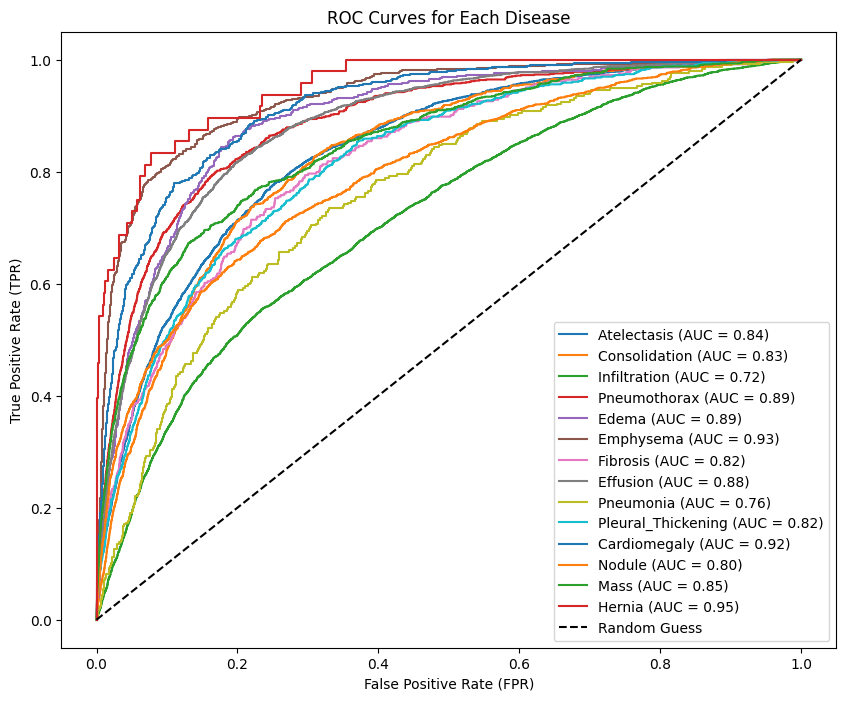

In [24]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {mean_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Random Guess")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Each Disease')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

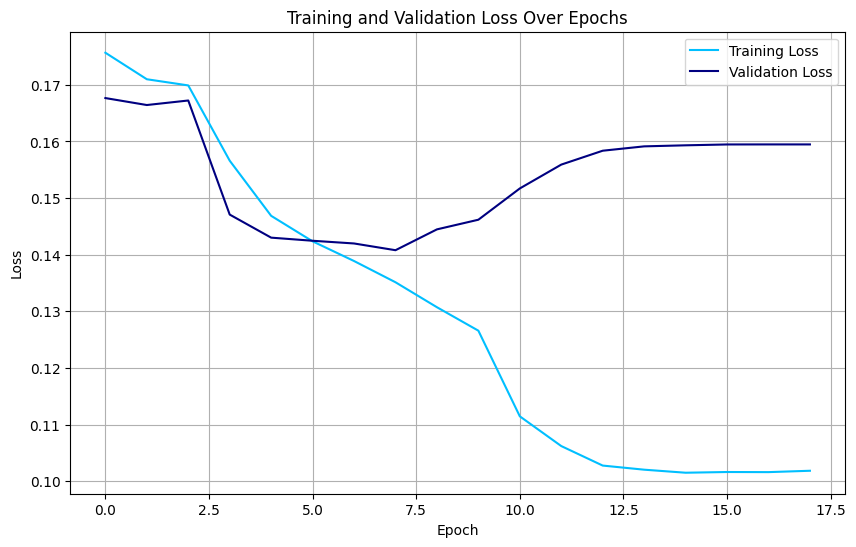

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss', color='deepskyblue')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

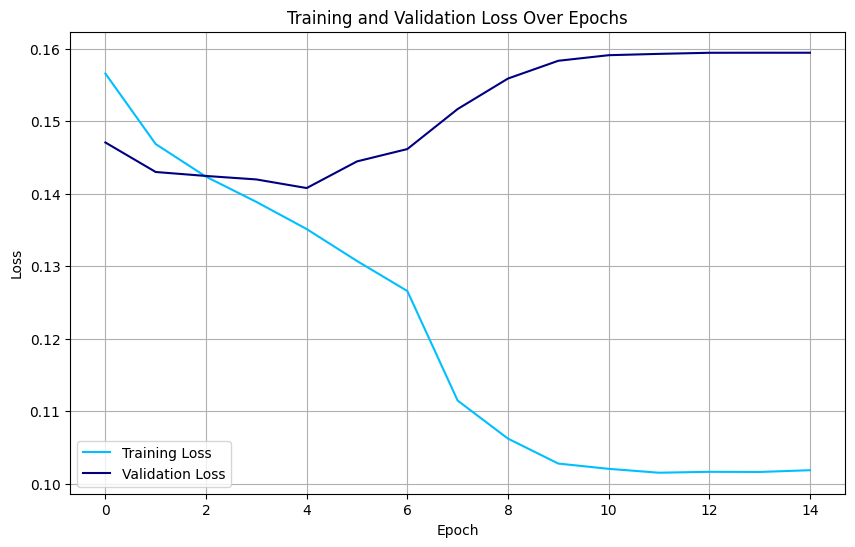

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss', color='deepskyblue')
plt.plot(val_losses_2, label='Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

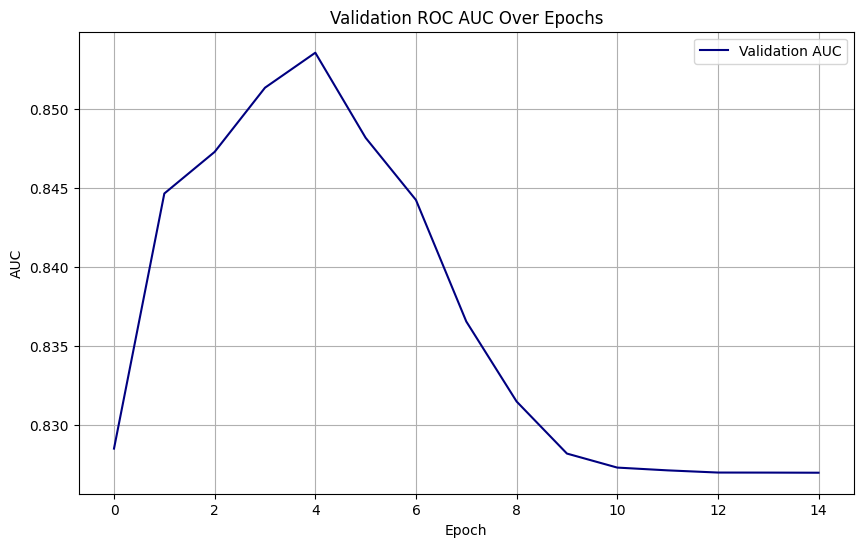

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC', color='navy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

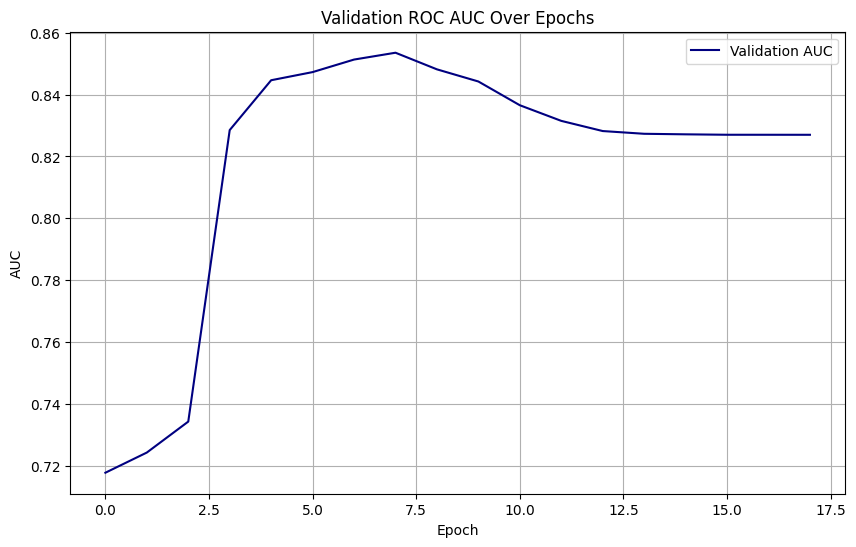

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC', color='navy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()